In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [6]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

In [55]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU(), stride=1):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

class DeconvLayer(nn.Module):
    def __init__(self, size, padding=1, stride=1, 
                 bn=False, dropout=False, activation_fn=nn.ReLU(), output_padding=0):
        super(DeconvLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(size[0], size[1], size[2], padding=padding, 
                                         stride=stride, output_padding=output_padding))
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [56]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [57]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, sparse=None, rho=1., optim_type='SGD', **optim_params):
        super(Net, self).__init__()
        
        self.sparse = sparse
        self.rho = rho
        
        self._conv1 = ConvLayer([1, 16, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv2 = ConvLayer([16, 32, 4], padding=0, bn=batchnorm, stride=2, 
                                pool_layer=None, activation_fn=nn.Tanh())
        self._conv3 = ConvLayer([32, 32, 3], padding=0, bn=batchnorm, stride=2, 
                                pool_layer=None, activation_fn=nn.Tanh())
        #self._conv4 = ConvLayer([64, 32, 2], padding=0, bn=batchnorm, stride=2, 
        #                        pool_layer=None, activation_fn=nn.Tanh())
        
        if self.sparse == 'KL':
            self.latent_fn = nn.Sigmoid()
        else:
            self.latent_fn = nn.Tanh()
            
        self.fce = FullyConnected([32*2*2, 64])
        self.fcd = FullyConnected([64, 32*2*2])
        
        #self._deconv1 = DeconvLayer([64, 64, 2], stride=2, padding=0, bn=batchnorm)
        self._deconv1 = DeconvLayer([32, 32, 3], stride=2, padding=0, bn=batchnorm)
        self._deconv2 = DeconvLayer([32, 16, 4], stride=2, padding=0, bn=batchnorm, output_padding=1)
        self._deconv3 = DeconvLayer([16, 1, 4], stride=2, padding=0, bn=batchnorm, activation_fn=nn.Tanh())
        
        self._loss = None
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
        
    def conv(self, x):
        l1 = self._conv1(x)       
        l2 = self._conv2(l1)        
        l3 = self._conv3(l2) 
        #print ("l3=", l3.shape)
        #l4 = self._conv3(l3)
        return l3, l2, l1
    
    def encode(self, x):
        l3 = self.conv(x)[0]       
        flatten = l3.view(-1, 32*2*2)       
        self.h = self.latent_fn(self.fce(flatten))
        return self.h
    
    def decode(self, h):
        flatten = self.fcd(h)
        l1 = flatten.view(-1, 32, 2, 2)
        l2 = self._deconv1(l1)
        l3 = self._deconv2(l2)
        #l4 = self._deconv2(l3)
        x = self._deconv3(l3)
        return x
        
    def forward(self, x):        
        h = self.encode(x)        
        x = self.decode(h)
        return x
    
    def loss(self, output, target):
        if self.sparse == 'KL':
            h_mean = self.h.mean(0)
            sparse_loss = - torch.log(h_mean) * self.rho - torch.log(1-h_mean) * (1-self.rho)
            self.sparse_loss = sparse_loss.mean()
        elif self.sparse == 'L1':
            h_abs = torch.abs(self.h)
            self.sparse_loss = self.rho * h_abs.mean()
        else:
            self.sparse_loss = 0.
                   
        self._loss = F.mse_loss(output, target) + self.sparse_loss
        
        return self._loss

In [58]:
models = {
    #'RMSProp KL': Net(False, False, sparse='KL', rho=0.2, optim_type='RMSProp', lr=1e-4),
    'RMSProp+bn L1': Net(True, False, sparse='L1', rho=0.01, optim_type='RMSProp', lr=1e-4),    
    'Adam KL': Net(False, False, sparse='KL', rho=0.2, optim_type='Adam', lr=1e-4),
    'Adam L1': Net(False, False, sparse='L1', rho=0.01, optim_type='Adam', lr=1e-4),
    'Adam+bn L1': Net(True, False, sparse='L1', rho=0.01, optim_type='Adam', lr=1e-4),
    'Adam+bn+dp L1': Net(True, True, sparse='L1', rho=0.01, optim_type='Adam', lr=1e-4)
}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [59]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)             
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss,))
        print(line + losses)

In [60]:
def test(models, loader, log=None):
    test_size = len(loader)
    test_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data).item() # sum up batch loss
    
    for k in models:
        test_loss[k] /= test_size
    report = 'Test losses: ' + ' '.join(['{}: {:.8f}\n'.format(k, test_loss[k]) for k in test_loss])
    if log is not None:
        for k in models:
            log[k].append((test_loss[k],))
    print(report)

In [61]:
for epoch in range(1, 61):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses RMSProp+bn L1: 1.299604 Adam KL: 1.552234 Adam L1: 0.843280 Adam+bn L1: 0.934947 Adam+bn+dp L1: 0.943758
Train Epoch: 1 [10000/50000 (20%)]	Losses RMSProp+bn L1: 0.506234 Adam KL: 1.074332 Adam L1: 0.535287 Adam+bn L1: 0.763196 Adam+bn+dp L1: 0.750639
Train Epoch: 1 [20000/50000 (40%)]	Losses RMSProp+bn L1: 0.458291 Adam KL: 0.921741 Adam L1: 0.399377 Adam+bn L1: 0.713341 Adam+bn+dp L1: 0.700014
Train Epoch: 1 [30000/50000 (60%)]	Losses RMSProp+bn L1: 0.422130 Adam KL: 0.874478 Adam L1: 0.377755 Adam+bn L1: 0.670132 Adam+bn+dp L1: 0.654730
Train Epoch: 1 [40000/50000 (80%)]	Losses RMSProp+bn L1: 0.364702 Adam KL: 0.871832 Adam L1: 0.384259 Adam+bn L1: 0.611799 Adam+bn+dp L1: 0.595964
Train Epoch: 1 [50000/50000 (100%)]	Losses RMSProp+bn L1: 0.329241 Adam KL: 0.855232 Adam L1: 0.379132 Adam+bn L1: 0.571474 Adam+bn+dp L1: 0.556710
Test losses: RMSProp+bn L1: 0.34358116
 Adam KL: 0.84347782
 Adam L1: 0.36616163
 Adam+bn L1: 0.57878273
 Adam+bn+dp L1: 0

Train Epoch: 9 [10000/50000 (20%)]	Losses RMSProp+bn L1: 0.038828 Adam KL: 0.583945 Adam L1: 0.040068 Adam+bn L1: 0.073246 Adam+bn+dp L1: 0.070598
Train Epoch: 9 [20000/50000 (40%)]	Losses RMSProp+bn L1: 0.034652 Adam KL: 0.577759 Adam L1: 0.035404 Adam+bn L1: 0.068470 Adam+bn+dp L1: 0.066448
Train Epoch: 9 [30000/50000 (60%)]	Losses RMSProp+bn L1: 0.035649 Adam KL: 0.576550 Adam L1: 0.035780 Adam+bn L1: 0.066197 Adam+bn+dp L1: 0.064842
Train Epoch: 9 [40000/50000 (80%)]	Losses RMSProp+bn L1: 0.032593 Adam KL: 0.568862 Adam L1: 0.033129 Adam+bn L1: 0.060919 Adam+bn+dp L1: 0.058890
Train Epoch: 9 [50000/50000 (100%)]	Losses RMSProp+bn L1: 0.030865 Adam KL: 0.566492 Adam L1: 0.032243 Adam+bn L1: 0.058892 Adam+bn+dp L1: 0.056959
Test losses: RMSProp+bn L1: 0.03117330
 Adam KL: 0.56925944
 Adam L1: 0.03304638
 Adam+bn L1: 0.05813882
 Adam+bn+dp L1: 0.05645836

Train Epoch: 10 [0/50000 (0%)]	Losses RMSProp+bn L1: 0.032168 Adam KL: 0.570065 Adam L1: 0.033327 Adam+bn L1: 0.059500 Adam+bn+dp L

Train Epoch: 17 [20000/50000 (40%)]	Losses RMSProp+bn L1: 0.019873 Adam KL: 0.550410 Adam L1: 0.023988 Adam+bn L1: 0.021281 Adam+bn+dp L1: 0.021485
Train Epoch: 17 [30000/50000 (60%)]	Losses RMSProp+bn L1: 0.018567 Adam KL: 0.543539 Adam L1: 0.020436 Adam+bn L1: 0.021061 Adam+bn+dp L1: 0.020570
Train Epoch: 17 [40000/50000 (80%)]	Losses RMSProp+bn L1: 0.018324 Adam KL: 0.549542 Adam L1: 0.023106 Adam+bn L1: 0.019515 Adam+bn+dp L1: 0.018904
Train Epoch: 17 [50000/50000 (100%)]	Losses RMSProp+bn L1: 0.021184 Adam KL: 0.553444 Adam L1: 0.025937 Adam+bn L1: 0.022108 Adam+bn+dp L1: 0.021933
Test losses: RMSProp+bn L1: 0.01754615
 Adam KL: 0.54806733
 Adam L1: 0.02299041
 Adam+bn L1: 0.01866254
 Adam+bn+dp L1: 0.01839418

Train Epoch: 18 [0/50000 (0%)]	Losses RMSProp+bn L1: 0.017396 Adam KL: 0.551741 Adam L1: 0.022900 Adam+bn L1: 0.019266 Adam+bn+dp L1: 0.018720
Train Epoch: 18 [10000/50000 (20%)]	Losses RMSProp+bn L1: 0.020043 Adam KL: 0.542533 Adam L1: 0.021221 Adam+bn L1: 0.019391 Adam+bn

Train Epoch: 25 [30000/50000 (60%)]	Losses RMSProp+bn L1: 0.014922 Adam KL: 0.541453 Adam L1: 0.018618 Adam+bn L1: 0.014479 Adam+bn+dp L1: 0.014312
Train Epoch: 25 [40000/50000 (80%)]	Losses RMSProp+bn L1: 0.014684 Adam KL: 0.538570 Adam L1: 0.018251 Adam+bn L1: 0.014389 Adam+bn+dp L1: 0.014619
Train Epoch: 25 [50000/50000 (100%)]	Losses RMSProp+bn L1: 0.016624 Adam KL: 0.542254 Adam L1: 0.019712 Adam+bn L1: 0.015193 Adam+bn+dp L1: 0.015034
Test losses: RMSProp+bn L1: 0.01463234
 Adam KL: 0.54022787
 Adam L1: 0.01885432
 Adam+bn L1: 0.01413742
 Adam+bn+dp L1: 0.01385863

Train Epoch: 26 [0/50000 (0%)]	Losses RMSProp+bn L1: 0.014071 Adam KL: 0.534740 Adam L1: 0.016714 Adam+bn L1: 0.013602 Adam+bn+dp L1: 0.013335
Train Epoch: 26 [10000/50000 (20%)]	Losses RMSProp+bn L1: 0.015142 Adam KL: 0.538751 Adam L1: 0.018424 Adam+bn L1: 0.015751 Adam+bn+dp L1: 0.014394
Train Epoch: 26 [20000/50000 (40%)]	Losses RMSProp+bn L1: 0.012402 Adam KL: 0.528134 Adam L1: 0.014989 Adam+bn L1: 0.013150 Adam+bn

Train Epoch: 33 [40000/50000 (80%)]	Losses RMSProp+bn L1: 0.015371 Adam KL: 0.535432 Adam L1: 0.016915 Adam+bn L1: 0.014680 Adam+bn+dp L1: 0.014222
Train Epoch: 33 [50000/50000 (100%)]	Losses RMSProp+bn L1: 0.014324 Adam KL: 0.536183 Adam L1: 0.017354 Adam+bn L1: 0.015366 Adam+bn+dp L1: 0.014548
Test losses: RMSProp+bn L1: 0.01324400
 Adam KL: 0.53566435
 Adam L1: 0.01664579
 Adam+bn L1: 0.01287864
 Adam+bn+dp L1: 0.01259355

Train Epoch: 34 [0/50000 (0%)]	Losses RMSProp+bn L1: 0.012853 Adam KL: 0.529712 Adam L1: 0.014229 Adam+bn L1: 0.012371 Adam+bn+dp L1: 0.011727
Train Epoch: 34 [10000/50000 (20%)]	Losses RMSProp+bn L1: 0.014179 Adam KL: 0.537261 Adam L1: 0.015809 Adam+bn L1: 0.013876 Adam+bn+dp L1: 0.014028
Train Epoch: 34 [20000/50000 (40%)]	Losses RMSProp+bn L1: 0.015382 Adam KL: 0.540917 Adam L1: 0.017956 Adam+bn L1: 0.014290 Adam+bn+dp L1: 0.014261
Train Epoch: 34 [30000/50000 (60%)]	Losses RMSProp+bn L1: 0.012496 Adam KL: 0.532480 Adam L1: 0.014356 Adam+bn L1: 0.012573 Adam+bn

KeyboardInterrupt: 

In [ ]:
torch.save(models['RMSProp KL'], './rms_kl_2')
torch.save(models['RMSProp+bn L1'], './rms_bn_l1_2')
torch.save(models['Adam KL'], './adam_kl_2')
torch.save(models['Adam L1'], './adam_l1_2')
torch.save(models['Adam+bn L1'], './adam_bn_l1_2')
torch.save(models['Adam+bn+dp L1'], './adam_bn_dp_l1_2')

## Вывод результатов

In [8]:
model = torch.load('./adam_kl')

In [9]:
data, _ = next(iter(test_loader))
output = model(data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = model.decode(torch.eye(32))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = model.encode(data)
    print((encoded > 0.2).sum(1))
    encoded[encoded < 0.2] = 0.
    decoded_f = model.decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([ 19,  13,  10,  21,  16,  10,  13,  17,  19,  14,   8,  12,
         21,  15,  16,   9,  20,  19,  20,  13,  22,   9,  18,   9,
         15,  20,  22,  14,  16,  12,  15,  11,  16,  14,  13,   9,
         18,  12,  10,  15,  10,  23,  17,   8,  14,   9,  18,  17,
         22,  18])


Исходные данные


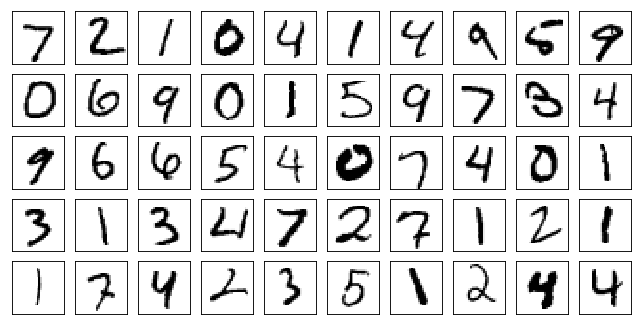

Выход декодера


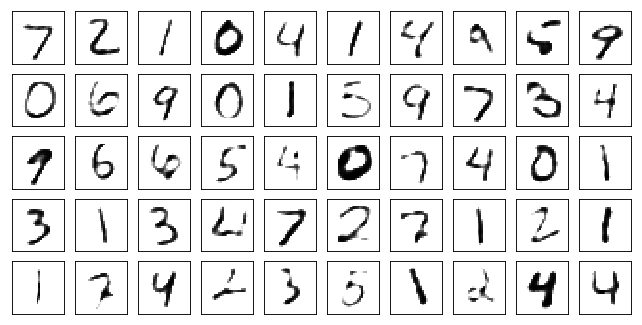

Выход декодера с отсечкой на латентном слое


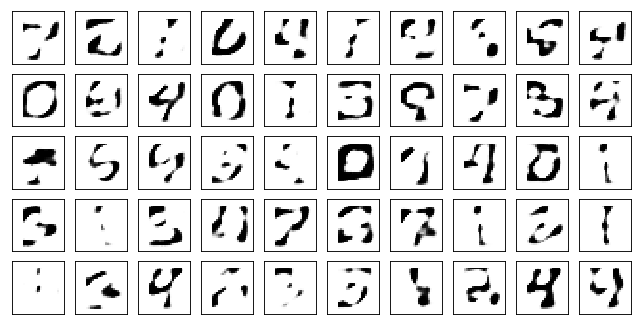

Выход декодера с единичной матрицы


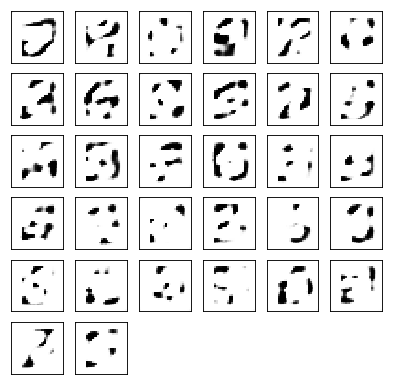

In [10]:
print ("Исходные данные")
plot_mnist(data.data.numpy(), (5, 10))
print ("Выход декодера")
plot_mnist(to_plot, (5, 10))
print ("Выход декодера с отсечкой на латентном слое")
plot_mnist(f_to_plot, (5, 10))
print ("Выход декодера с единичной матрицы")
plot_mnist(dec_to_plot, (6, 6))

In [11]:
model = torch.load('./adam_bn_l1')

In [12]:
data, _ = next(iter(test_loader))
output = model(data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = model.decode(torch.eye(32))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = model.encode(data)
    print((np.abs(encoded) > 0.1).sum(1))
    encoded[np.abs(encoded) < 0.1] = 0.
    decoded_f = model.decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([  7,  16,   3,   8,   7,   3,   8,  13,  14,   8,  11,  11,
          5,   6,   3,   9,   6,   5,  11,   7,   7,   7,  10,   9,
          8,  14,  10,   6,   7,   8,   8,   5,   8,  12,   9,  11,
          7,   6,   7,   4,   4,   8,   8,  11,   8,   4,  11,   8,
          8,  12])


Исходные данные


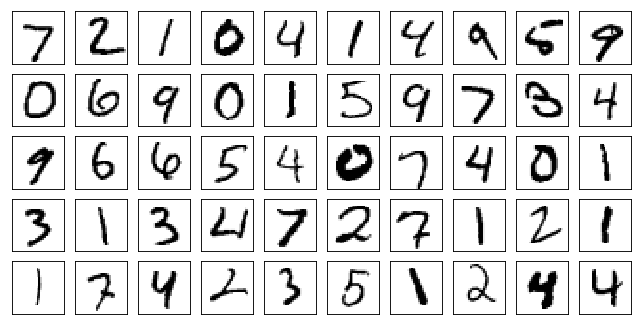

Выход декодера


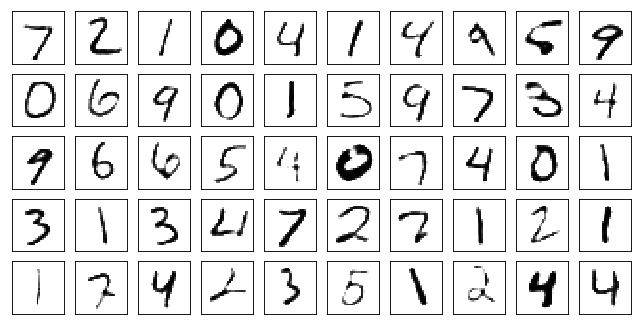

Выход декодера с отсечкой на латентном слое


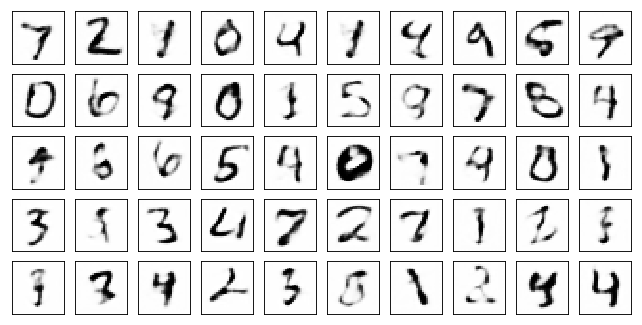

Выход декодера с единичной матрицы


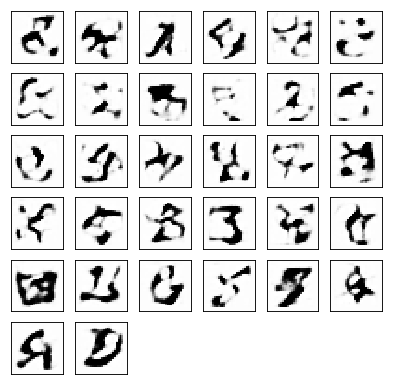

In [13]:
print ("Исходные данные")
plot_mnist(data.data.numpy(), (5, 10))
print ("Выход декодера")
plot_mnist(to_plot, (5, 10))
print ("Выход декодера с отсечкой на латентном слое")
plot_mnist(f_to_plot, (5, 10))
print ("Выход декодера с единичной матрицы")
plot_mnist(dec_to_plot, (6, 6))

### Оптимизация изображений на входе автокодировщика

In [14]:
model = torch.load('./adam_bn_l1')

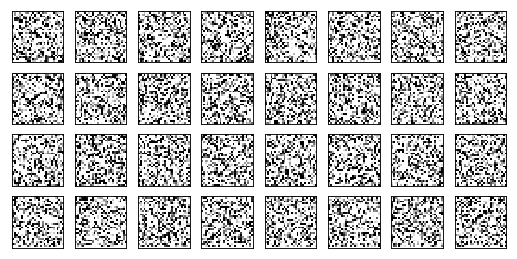

In [15]:
img = torch.randn((32, 784)).view(-1, 1, 28, 28)
to_plot = img.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (8, 8))

In [16]:
from torch.autograd import Variable

def generate_image(img):
    
    gen_img_par = Variable(img, requires_grad=True)
    latent_vector = torch.eye(32)
    loss_stats = []
    steps_since_lr_decreased = 0
    lr = 1e-3
    
    
    for i in range(1, 500001):  
                
        target = model.encode(F.sigmoid(gen_img_par))
                
        gen_optim = optim.Adam([gen_img_par], lr=lr, weight_decay=0.)
        gen_optim.zero_grad()
        loss = F.mse_loss(target, latent_vector)    
        loss.backward()                   
        gen_optim.step()
        
        if i % 5000 == 0:    
            print ("Iteration {}: loss={}".format(i,loss))
            ls = loss.detach().numpy()            
            loss_stats.append(ls)
        
                       
            if len(loss_stats) > 10:    
                down = False    
                for k in range(2, 7):    
                    if ls < loss_stats[-k]:
                        down = True
                        break
                # Loss is rising for 5 last epochs - decrease LR
                if not down and steps_since_lr_decreased > 10:
                    lr = lr * 0.5
                    steps_since_lr_decreased = 0
                    print ("Decreasing LR ..")
                    if lr < 1e-6:
                        print ("Stop ..")
                        break
                
                steps_since_lr_decreased += 1

        if i % 50000 == 0:
            to_plot = gen_img_par.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
            plot_mnist(to_plot, (8, 8))
                        
    return gen_img_par    

In [ ]:
new_image_randn = generate_image(img)

Iteration 5000: loss=0.028091736137866974
Iteration 10000: loss=0.026011934503912926
Iteration 15000: loss=0.025517471134662628


### Оптимизация изображений - фильтры энкодера

In [34]:
def generate_filter_image(img):
    
    gen_img_par = Variable(img, requires_grad=True)
    latent_vector = torch.eye(16)
    loss_stats = []
    steps_since_lr_decreased = 0
    lr = 1e-4
        
    for i in range(1, 1000001):  
                
        target = model._conv1(F.sigmoid(gen_img_par))
        
        gen_optim = optim.Adam([gen_img_par], lr=lr, weight_decay=0.)
        gen_optim.zero_grad()
        loss = F.mse_loss(target.view(16, 16), latent_vector)    
        loss.backward()                   
        gen_optim.step()
        
        if i % 5000 == 0:    
            print ("Iteration {}: loss={}".format(i,loss))
            ls = loss.detach().numpy()            
            loss_stats.append(ls)
                        
            if len(loss_stats) > 10:    
                down = False    
                for k in range(2, 7):    
                    if ls < loss_stats[-k]:
                        down = True
                        break
                # Loss is rising for 5 last epochs - decrease LR
                if not down and steps_since_lr_decreased > 10:
                    lr = lr * 0.5
                    steps_since_lr_decreased = 0
                    print ("Decreasing LR ..")
                    if lr < 1e-6:
                        print ("Stop ..")
                        break
                
                steps_since_lr_decreased += 1

        if i % 50000 == 0:
            to_plot = gen_img_par.view(-1, 1, 4, 4).clamp(0, 1).data.numpy()
            plot_mnist(to_plot, (4, 4))
                        
    return gen_img_par    

In [35]:
img = torch.randn((16, 16)).view(16, 1, 4, 4)

Iteration 5000: loss=0.26716849207878113
Iteration 10000: loss=0.23293666541576385
Iteration 15000: loss=0.20588669180870056
Iteration 20000: loss=0.18568061292171478
Iteration 25000: loss=0.17129957675933838
Iteration 30000: loss=0.16149002313613892
Iteration 35000: loss=0.15502560138702393
Iteration 40000: loss=0.15087999403476715
Iteration 45000: loss=0.14827261865139008
Iteration 50000: loss=0.14665351808071136


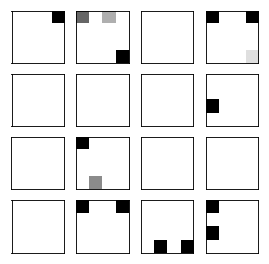

Iteration 55000: loss=0.14565663039684296
Iteration 60000: loss=0.1450454443693161
Iteration 65000: loss=0.1446714997291565
Iteration 70000: loss=0.14444240927696228
Iteration 75000: loss=0.1443014293909073
Iteration 80000: loss=0.14421403408050537
Iteration 85000: loss=0.1441592276096344
Iteration 90000: loss=0.14412422478199005
Iteration 95000: loss=0.1441013067960739
Iteration 100000: loss=0.14408594369888306


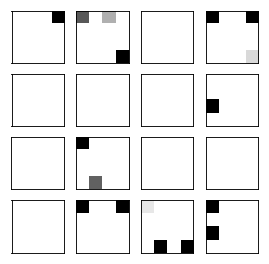

Iteration 105000: loss=0.14407525956630707
Iteration 110000: loss=0.1440676897764206
Iteration 115000: loss=0.1440621018409729
Iteration 120000: loss=0.14405794441699982
Iteration 125000: loss=0.1440545618534088
Iteration 130000: loss=0.1440519541501999
Iteration 135000: loss=0.14404988288879395
Iteration 140000: loss=0.1440480798482895
Iteration 145000: loss=0.1440466344356537
Iteration 150000: loss=0.1440454125404358


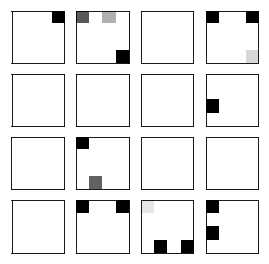

Iteration 155000: loss=0.14404432475566864
Iteration 160000: loss=0.1440434455871582
Iteration 165000: loss=0.14404259622097015
Iteration 170000: loss=0.14404188096523285
Iteration 175000: loss=0.1440412849187851
Iteration 180000: loss=0.1440407782793045
Iteration 185000: loss=0.1440402716398239
Iteration 190000: loss=0.14403976500034332
Iteration 195000: loss=0.1440393179655075
Iteration 200000: loss=0.14403896033763885


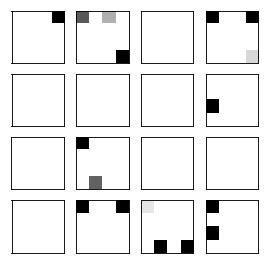

Iteration 205000: loss=0.14403864741325378
Iteration 210000: loss=0.14403830468654633
Iteration 215000: loss=0.14403802156448364
Iteration 220000: loss=0.14403779804706573
Iteration 225000: loss=0.14403754472732544
Iteration 230000: loss=0.14403733611106873
Iteration 235000: loss=0.14403709769248962
Iteration 240000: loss=0.1440368890762329
Iteration 245000: loss=0.14403674006462097
Iteration 250000: loss=0.14403656125068665


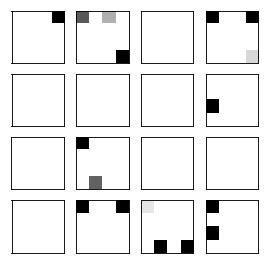

Iteration 255000: loss=0.14403636753559113
Iteration 260000: loss=0.144036203622818
Iteration 265000: loss=0.14403606951236725
Iteration 270000: loss=0.14403590559959412
Iteration 275000: loss=0.14403580129146576
Iteration 280000: loss=0.1440356820821762
Iteration 285000: loss=0.14403557777404785
Iteration 290000: loss=0.1440354287624359
Iteration 295000: loss=0.14403533935546875
Iteration 300000: loss=0.1440352499485016


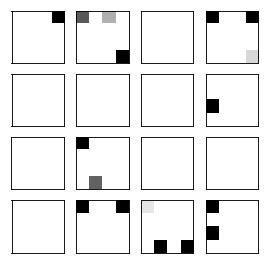

Iteration 305000: loss=0.14403514564037323
Iteration 310000: loss=0.14403507113456726
Iteration 315000: loss=0.14403493702411652
Iteration 320000: loss=0.14403486251831055
Iteration 325000: loss=0.14403483271598816
Iteration 330000: loss=0.1440347284078598
Iteration 335000: loss=0.14403465390205383
Iteration 340000: loss=0.14403459429740906
Iteration 345000: loss=0.1440344899892807
Iteration 350000: loss=0.1440344601869583


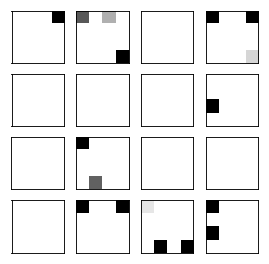

Iteration 355000: loss=0.14403440058231354
Iteration 360000: loss=0.14403434097766876
Iteration 365000: loss=0.14403431117534637
Iteration 370000: loss=0.1440342366695404
Iteration 375000: loss=0.14403414726257324
Iteration 380000: loss=0.14403411746025085
Iteration 385000: loss=0.14403411746025085
Iteration 390000: loss=0.14403404295444489
Iteration 395000: loss=0.1440340131521225
Iteration 400000: loss=0.1440339833498001


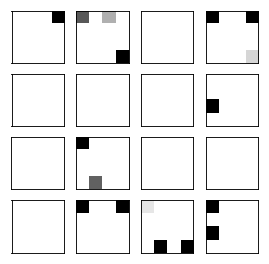

Iteration 405000: loss=0.14403393864631653
Iteration 410000: loss=0.14403386414051056
Iteration 415000: loss=0.14403387904167175
Iteration 420000: loss=0.1440337896347046
Iteration 425000: loss=0.1440337598323822
Iteration 430000: loss=0.14403371512889862
Iteration 435000: loss=0.14403368532657623


KeyboardInterrupt: 

In [36]:
filter_img = generate_filter_image(img)